In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
import torch.optim as optim
import random
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, 'over9000/')
from ralamb import Ralamb
from radam import RAdam
from ranger import Ranger
from lookahead import LookaheadAdam
from over9000 import Over9000
from tqdm import tqdm_notebook as tqdm

#For Transformations
import cv2
import glob
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader, sampler
import albumentations as aug
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose,Cutout, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations.pytorch import ToTensor
from albumentations.augmentations.transforms import CropNonEmptyMaskIfExists

# For Meter
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import jaccard_similarity_score as jaccard_score
from sklearn.model_selection import train_test_split

In [2]:
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
seed_everything(43)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

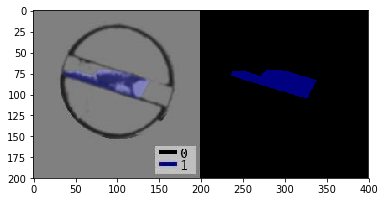

In [4]:
img = cv2.imread('data/0.jpg')
mask = cv2.imread('data/0.png')
res = np.hstack([img, mask])
plt.imshow(res)

### Replace with whatever extension your mask has, as in our case it is png

In [9]:
class SensoVisionDataset(Dataset):
    def __init__(self, phase):
        self.transforms = get_transforms(phase)
        self.phase = phase
        train = glob.glob('data/*.png')  # >>>>>>>>>>>>>>>> Replace here
        self.train, self.val = train_test_split(train, test_size = 0.2)
        self.dim = (256, 256)
    def __getitem__(self, idx):
        if self.phase == 'train':
            img = cv2.imread(self.train[idx][:-3]+'jpg')
            img = cv2.resize(img, self.dim, interpolation = cv2.INTER_NEAREST)  # Resizing to fit with EfficientNet
            mask = cv2.imread(self.train[idx], 0)
            mask = cv2.resize(mask, self.dim, interpolation = cv2.INTER_NEAREST)
        elif self.phase == 'val':
            img = cv2.imread(self.val[idx][:-3]+'jpg')
            img = cv2.resize(img, self.dim, interpolation = cv2.INTER_NEAREST)
            mask = cv2.imread(self.val[idx], 0)
            mask = cv2.resize(mask, self.dim, interpolation = cv2.INTER_NEAREST)
        mask = (mask != 0)*255 
        mask = mask.astype(np.uint8)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        return img, mask

    def __len__(self):
        if self.phase == 'train':
            return len(self.train)
        else:
            return len(self.val)

In [10]:
def get_transforms(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend([
             aug.Flip()
            ])

    list_transforms.extend(
        [
#             Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [11]:
def provider(phase, batch_size=8, num_workers=0):
    '''Returns dataloader for the model training'''
    if phase == 'train':
        image_dataset = SensoVisionDataset(phase)
    elif phase == 'val':
        image_dataset = SensoVisionDataset(phase)
        
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=False,
        shuffle=True,   
    )

    return dataloader

In [12]:
dl = provider('train')

In [13]:
for img, mask in dl:
    print(img.shape)
    print(mask.shape)
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


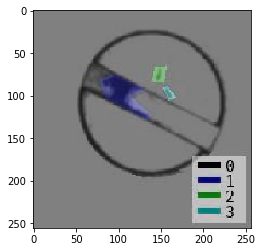

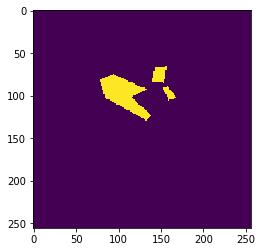

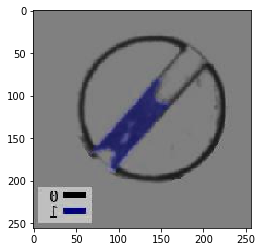

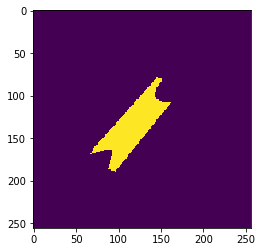

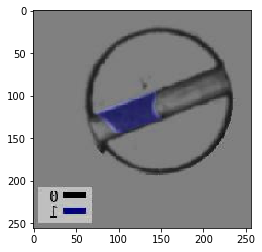

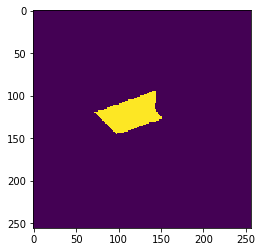

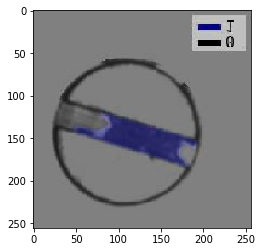

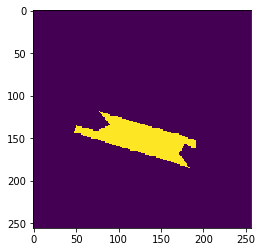

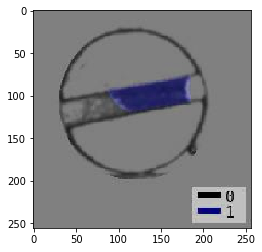

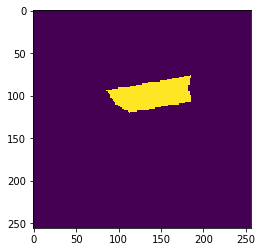

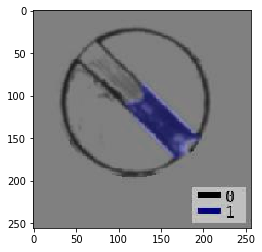

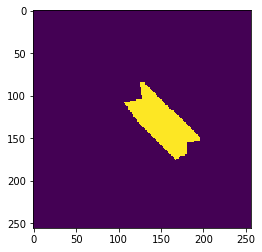

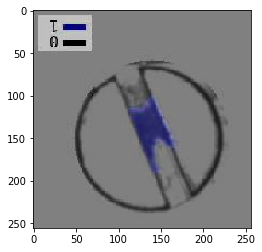

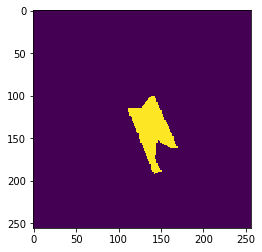

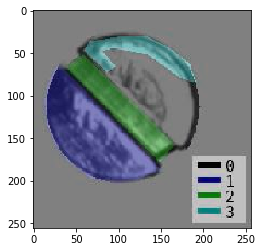

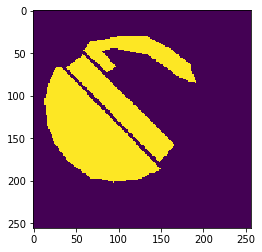

In [14]:
for i in range(img.shape[0]):
    image = img[i].permute(1, 2, 0).cpu().numpy()
    msk = mask[i].squeeze(0).cpu().numpy()
    plt.imshow(image)
    plt.show()
    plt.imshow(msk)
    plt.show()

In [15]:
class BCEDiceLoss(nn.Module):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, beta=2., activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        bce = self.bce(y_pr, y_gt)
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return dice + bce

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, beta=2., activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return dice

In [16]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = (y_true * y_pred_bin).sum()
    if (y_true.sum()==0 and y_pred_bin.sum()==0):
        return 1
    return (2*intersection) / (y_true.sum() + y_pred_bin.sum())


def dice_metric_train(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float()
    y_true = y_true.float()
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, j, ...],y_pred_bin[i, j, ...])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel


def dice_metric(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float().detach().cpu().numpy()
    y_true = y_true.float().detach().cpu().numpy()
    batch_size = y_true.shape[0]
    dice = []
    precision = []
    recall = []
    for i in range(batch_size):
        p, r, fb_score, support = precision_recall_fscore_support( ((y_true[i]> 0).astype(np.uint8)).flatten(), ((y_pred_bin[i]> 0).astype(np.uint8)).flatten(), average='binary')
        dice.append(fb_score)
        precision.append(p)
        recall.append(r)
    return np.mean(dice), np.mean(precision), np.mean(recall)


class Meter:
    '''A meter to keep track of loss and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.phase = phase


    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice = dice_metric_train(probs, targets)
        self.base_dice_scores.append(dice)
        
    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        return dice

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dice = meter.get_metrics()
    print("Loss: %0.4f | dice: %0.4f" % (epoch_loss, dice))
    return dice

In [17]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self,model, optim, loss, lr, bs, name, shape=512, crop_type=0):
        self.num_workers = 4
        self.batch_size = {"train": bs, "val": 1}
        self.accumulation_steps = bs // self.batch_size['train']
        self.lr = lr
        self.loss = loss
        self.optim = optim
        self.num_epochs = 0
        self.best_val_loss = 1
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.name = name
        self.do_cutmix = True
        self.loss_classification = torch.nn.CrossEntropyLoss()
        if self.loss == 'BCE':
            self.criterion = torch.nn.BCEWithLogitsLoss()
        elif self.loss == 'BCE+DICE':
            self.criterion = BCEDiceLoss(threshold=None)  #MODIFIED
        elif self.loss == 'TVERSKY':
            self.criterion = Tversky()
        elif self.loss == 'Dice' or self.loss == 'DICE':
            self.criterion = DiceLoss()
        elif self.loss == 'BCE+DICE+JACCARD':
            self.criterion = BCEDiceJaccardLoss(threshold=None)
        else:
            raise(Exception(f'{self.loss} is not recognized. Please provide a valid loss function.'))

        # Optimizers
        if self.optim == 'Over9000':
            self.optimizer = Over9000(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Adam':
            self.optimizer = torch.optim.Adam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'RAdam':
            self.optimizer = Radam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ralamb':
            self.optimizer = Ralamb(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ranger':
            self.optimizer = Ranger(self.net.parameters(),lr=self.lr)
        elif self.optim == 'LookaheadAdam':
            self.optimizer = LookaheadAdam(self.net.parameters(),lr=self.lr)
        else:
            raise(Exception(f'{self.optim} is not recognized. Please provide a valid optimizer function.'))
            
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.5, mode="min", patience=4, verbose=True, min_lr = 1e-5)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        
        self.dataloaders = {
            phase: provider(
                phase=phase,
                num_workers=0,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}

    def freeze(self):
        for  name, param in self.net.encoder.named_parameters():
            if name.find('bn') != -1:
                param.requires_grad=True
            else:
                param.requires_grad=False
                
    def seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    def load_model(self, name, path='models/'):
        state = torch.load(path+name, map_location=lambda storage, loc: storage)
        self.net.load_state_dict(state['state_dict'])
        self.optimizer.load_state_dict(state['optimizer'])
        print("Loaded model with dice: ", state['best_dice'])
            
    def unfreeze(self):
        for param in self.net.parameters():
            param.requires_grad=True
     
    def forward(self, images, targets):
        images = images.to(self.device)
        targets = targets.to(self.device)
        preds = self.net(images)
        loss = self.criterion(preds, targets)
        return loss, targets, preds
    
    def cutmix(self,batch, alpha):
        data, targets = batch
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_targets = targets[indices]
        lam = np.random.beta(alpha, alpha)
        image_h, image_w = data.shape[2:]
        cx = np.random.uniform(0, image_w)
        cy = np.random.uniform(0, image_h)
        w = image_w * np.sqrt(1 - lam)
        h = image_h * np.sqrt(1 - lam)
        x0 = int(np.round(max(cx - w / 2, 0)))
        x1 = int(np.round(min(cx + w / 2, image_w)))
        y0 = int(np.round(max(cy - h / 2, 0)))
        y1 = int(np.round(min(cy + h / 2, image_h)))
        data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
        targets[:, :, y0:y1, x0:x1] = shuffled_targets[:, :, y0:y1, x0:x1]
        return data, targets

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            if phase == "train" and self.do_cutmix:
                images, targets = self.cutmix(batch, 0.5)
            else:
                images, targets = batch
            seg_loss, outputs, preds = self.forward(images, targets)
            loss = seg_loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1)
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            preds = preds.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        torch.cuda.empty_cache()
        return epoch_loss, dice

    def train_end(self):
        train_dice = self.dice_scores["train"]
        train_loss = self.losses["train"]
        
        val_dice = self.dice_scores["val"]
        val_loss = self.losses["val"]

        df_data=np.array([train_loss,train_dice, val_loss,val_dice]).T
        df = pd.DataFrame(df_data,columns = ['train_loss','train_dice', 'val_loss','val_dice'])
        df.to_csv('logs/'+self.name+'.csv')

    def fit(self, epochs):
        self.num_epochs+=epochs
        for epoch in range(self.num_epochs-epochs, self.num_epochs):
            self.net.train()
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_val_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            self.net.eval()
            with torch.no_grad():
                val_loss, val_dice = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_val_loss:
                print("* New optimal found according to Validation loss!, saving state *")
                state["best_loss"] = self.best_val_loss = val_loss
                os.makedirs('models/', exist_ok=True)
                torch.save(state, 'models/'+self.name+'_best_loss.pth')
            print()
            self.train_end()

In [18]:
import segmentation_models_pytorch as smp

In [23]:
MODEL = 'FPN'   # >>>>>> Other options: FPN, Linknet
ENCODER = 'efficientnet-b4'  # >>>>>> For other options: 
if(MODEL == 'Unet'):
    model = smp.Unet(ENCODER, encoder_weights='imagenet', classes=1, activation=None)
elif(MODEL == 'FPN'):
    model = smp.FPN(ENCODER, encoder_weights='imagenet', classes=1, activation=None)
elif(MODEL == 'Linknet'):
    model = smp.Linknet(ENCODER, encoder_weights='imagenet', classes=1, activation=None)

In [24]:
trainer = Trainer(model = model, optim = 'Ranger', loss = 'Dice', lr = 1e-3, bs = 16, name ='Ranger_Dice_Beta_1')
trainer.seed_everything(42)
trainer.do_cutmix = False
trainer.freeze()
trainer.fit(10)
trainer.do_cutmix = True
trainer.unfreeze()
trainer.fit(10)
trainer.do_cutmix = False
trainer.freeze()
trainer.fit(10)
trainer.unfreeze()
trainer.fit(10)

  0%|          | 0/11 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 08:48:01


 67%|██████▋   | 2/3 [00:00<00:00, 12.64it/s, loss=0.735]

Loss: 0.8232 | dice: 1.0000
Starting epoch: 0 | phase: val | ⏰: 08:48:03


100%|██████████| 3/3 [00:00<00:00, 13.70it/s, loss=0.758]


Loss: 0.7580 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 1 | phase: train | ⏰: 08:48:04


 67%|██████▋   | 2/3 [00:00<00:00, 12.30it/s, loss=0.501]

Loss: 0.7335 | dice: 1.0000
Starting epoch: 1 | phase: val | ⏰: 08:48:07


100%|██████████| 3/3 [00:00<00:00, 13.26it/s, loss=0.475]


Loss: 0.4751 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 2 | phase: train | ⏰: 08:48:08


 67%|██████▋   | 2/3 [00:00<00:00, 12.61it/s, loss=0.494]

Loss: 0.3125 | dice: 1.0000
Starting epoch: 2 | phase: val | ⏰: 08:48:10


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.4760 | dice: 1.0000

Starting epoch: 3 | phase: train | ⏰: 08:48:10


 67%|██████▋   | 2/3 [00:00<00:00, 12.55it/s, loss=0.322]

Loss: 0.1267 | dice: 1.0000
Starting epoch: 3 | phase: val | ⏰: 08:48:13


100%|██████████| 3/3 [00:00<00:00, 13.62it/s, loss=0.425]


Loss: 0.4253 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 4 | phase: train | ⏰: 08:48:14


 67%|██████▋   | 2/3 [00:00<00:00, 12.39it/s, loss=0.49]

Loss: 0.0873 | dice: 1.0000
Starting epoch: 4 | phase: val | ⏰: 08:48:16


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.4511 | dice: 1.0000

Starting epoch: 5 | phase: train | ⏰: 08:48:17


 67%|██████▋   | 2/3 [00:00<00:00, 12.34it/s, loss=0.431]

Loss: 0.0730 | dice: 1.0000
Starting epoch: 5 | phase: val | ⏰: 08:48:19


100%|██████████| 3/3 [00:00<00:00, 13.35it/s, loss=0.401]


Loss: 0.4007 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 6 | phase: train | ⏰: 08:48:20


 67%|██████▋   | 2/3 [00:00<00:00, 12.65it/s, loss=0.502]

Loss: 0.0646 | dice: 1.0000
Starting epoch: 6 | phase: val | ⏰: 08:48:23


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.4723 | dice: 1.0000

Starting epoch: 7 | phase: train | ⏰: 08:48:23


 67%|██████▋   | 2/3 [00:00<00:00, 12.62it/s, loss=0.262]

Loss: 0.0585 | dice: 1.0000
Starting epoch: 7 | phase: val | ⏰: 08:48:25


100%|██████████| 3/3 [00:00<00:00, 13.62it/s, loss=0.332]


Loss: 0.3322 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 8 | phase: train | ⏰: 08:48:26


 67%|██████▋   | 2/3 [00:00<00:00, 12.29it/s, loss=0.355]

Loss: 0.0536 | dice: 1.0000
Starting epoch: 8 | phase: val | ⏰: 08:48:29


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.3373 | dice: 1.0000

Starting epoch: 9 | phase: train | ⏰: 08:48:29


 67%|██████▋   | 2/3 [00:00<00:00, 12.68it/s, loss=0.339]

Loss: 0.0523 | dice: 1.0000
Starting epoch: 9 | phase: val | ⏰: 08:48:31


100%|██████████| 3/3 [00:00<00:00, 13.70it/s, loss=0.31] 


Loss: 0.3104 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 10 | phase: train | ⏰: 08:48:32


 67%|██████▋   | 2/3 [00:00<00:00, 12.51it/s, loss=0.218]

Loss: 0.0609 | dice: 1.0000
Starting epoch: 10 | phase: val | ⏰: 08:48:36


100%|██████████| 3/3 [00:00<00:00, 13.60it/s, loss=0.277]


Loss: 0.2772 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 11 | phase: train | ⏰: 08:48:39


 67%|██████▋   | 2/3 [00:00<00:00, 12.57it/s, loss=0.258]

Loss: 0.0594 | dice: 1.0000
Starting epoch: 11 | phase: val | ⏰: 08:48:42


100%|██████████| 3/3 [00:00<00:00, 13.67it/s, loss=0.232]


Loss: 0.2321 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 12 | phase: train | ⏰: 08:48:45


 67%|██████▋   | 2/3 [00:00<00:00, 12.28it/s, loss=0.232]

Loss: 0.0539 | dice: 1.0000
Starting epoch: 12 | phase: val | ⏰: 08:48:49


100%|██████████| 3/3 [00:00<00:00, 13.36it/s, loss=0.207]


Loss: 0.2070 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 13 | phase: train | ⏰: 08:48:51


 67%|██████▋   | 2/3 [00:00<00:00, 12.38it/s, loss=0.243]

Loss: 0.0486 | dice: 1.0000
Starting epoch: 13 | phase: val | ⏰: 08:48:55


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.2132 | dice: 1.0000

Starting epoch: 14 | phase: train | ⏰: 08:48:55


 67%|██████▋   | 2/3 [00:00<00:00, 12.32it/s, loss=0.159]

Loss: 0.0494 | dice: 1.0000
Starting epoch: 14 | phase: val | ⏰: 08:48:59


100%|██████████| 3/3 [00:00<00:00, 13.41it/s, loss=0.145]


Loss: 0.1447 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 15 | phase: train | ⏰: 08:49:01


 67%|██████▋   | 2/3 [00:00<00:00, 12.63it/s, loss=0.152]

Loss: 0.0468 | dice: 1.0000
Starting epoch: 15 | phase: val | ⏰: 08:49:05


100%|██████████| 3/3 [00:00<00:00, 13.71it/s, loss=0.133]


Loss: 0.1334 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 16 | phase: train | ⏰: 08:49:08


 67%|██████▋   | 2/3 [00:00<00:00, 12.35it/s, loss=0.148]

Loss: 0.0432 | dice: 1.0000
Starting epoch: 16 | phase: val | ⏰: 08:49:11


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.1391 | dice: 1.0000

Starting epoch: 17 | phase: train | ⏰: 08:49:12


 67%|██████▋   | 2/3 [00:00<00:00, 12.42it/s, loss=0.121]

Loss: 0.0432 | dice: 1.0000
Starting epoch: 17 | phase: val | ⏰: 08:49:15


100%|██████████| 3/3 [00:00<00:00, 13.49it/s, loss=0.0996]


Loss: 0.0996 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 18 | phase: train | ⏰: 08:49:18


 67%|██████▋   | 2/3 [00:00<00:00, 12.47it/s, loss=0.154]

Loss: 0.0408 | dice: 1.0000
Starting epoch: 18 | phase: val | ⏰: 08:49:22


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.1334 | dice: 1.0000

Starting epoch: 19 | phase: train | ⏰: 08:49:22


 67%|██████▋   | 2/3 [00:00<00:00, 12.39it/s, loss=0.0629]

Loss: 0.0418 | dice: 1.0000
Starting epoch: 19 | phase: val | ⏰: 08:49:25


100%|██████████| 3/3 [00:00<00:00, 13.38it/s, loss=0.0967]


Loss: 0.0967 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 20 | phase: train | ⏰: 08:49:28


 67%|██████▋   | 2/3 [00:00<00:00, 12.37it/s, loss=0.0949]

Loss: 0.0342 | dice: 1.0000
Starting epoch: 20 | phase: val | ⏰: 08:49:31


100%|██████████| 3/3 [00:00<00:00, 13.45it/s, loss=0.0827]


Loss: 0.0827 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 21 | phase: train | ⏰: 08:49:34


 67%|██████▋   | 2/3 [00:00<00:00, 12.59it/s, loss=0.0966]

Loss: 0.0341 | dice: 1.0000
Starting epoch: 21 | phase: val | ⏰: 08:49:37


100%|██████████| 3/3 [00:00<00:00, 13.67it/s, loss=0.0825]


Loss: 0.0825 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 22 | phase: train | ⏰: 08:49:40


 67%|██████▋   | 2/3 [00:00<00:00, 12.45it/s, loss=0.0793]

Loss: 0.0316 | dice: 1.0000
Starting epoch: 22 | phase: val | ⏰: 08:49:43


100%|██████████| 3/3 [00:00<00:00, 13.52it/s, loss=0.0681]


Loss: 0.0681 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 23 | phase: train | ⏰: 08:49:46


 67%|██████▋   | 2/3 [00:00<00:00, 12.61it/s, loss=0.043]

Loss: 0.0353 | dice: 1.0000
Starting epoch: 23 | phase: val | ⏰: 08:49:49


100%|██████████| 3/3 [00:00<00:00, 13.69it/s, loss=0.0585]


Loss: 0.0585 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 24 | phase: train | ⏰: 08:49:51


 67%|██████▋   | 2/3 [00:00<00:00, 12.12it/s, loss=0.0536]

Loss: 0.0330 | dice: 1.0000
Starting epoch: 24 | phase: val | ⏰: 08:49:54


100%|██████████| 3/3 [00:00<00:00, 13.22it/s, loss=0.0454]


Loss: 0.0454 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 25 | phase: train | ⏰: 08:49:57


 67%|██████▋   | 2/3 [00:00<00:00, 12.58it/s, loss=0.0529]

Loss: 0.0328 | dice: 1.0000
Starting epoch: 25 | phase: val | ⏰: 08:50:00


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0479 | dice: 1.0000

Starting epoch: 26 | phase: train | ⏰: 08:50:00


 67%|██████▋   | 2/3 [00:00<00:00, 12.37it/s, loss=0.0607]

Loss: 0.0311 | dice: 1.0000
Starting epoch: 26 | phase: val | ⏰: 08:50:03


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0525 | dice: 1.0000

Starting epoch: 27 | phase: train | ⏰: 08:50:03


 67%|██████▋   | 2/3 [00:00<00:00, 12.48it/s, loss=0.0521]

Loss: 0.0313 | dice: 1.0000
Starting epoch: 27 | phase: val | ⏰: 08:50:06


100%|██████████| 3/3 [00:00<00:00, 13.52it/s, loss=0.0451]


Loss: 0.0451 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 28 | phase: train | ⏰: 08:50:09


 67%|██████▋   | 2/3 [00:00<00:00, 12.52it/s, loss=0.0466]

Loss: 0.0306 | dice: 1.0000
Starting epoch: 28 | phase: val | ⏰: 08:50:12


100%|██████████| 3/3 [00:00<00:00, 13.50it/s, loss=0.0408]


Loss: 0.0408 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 29 | phase: train | ⏰: 08:50:15


 67%|██████▋   | 2/3 [00:00<00:00, 12.17it/s, loss=0.052]

Loss: 0.0301 | dice: 1.0000
Starting epoch: 29 | phase: val | ⏰: 08:50:18


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0462 | dice: 1.0000

Starting epoch: 30 | phase: train | ⏰: 08:50:18


 67%|██████▋   | 2/3 [00:00<00:00, 12.21it/s, loss=0.0549]

Loss: 0.0300 | dice: 1.0000
Starting epoch: 30 | phase: val | ⏰: 08:50:21


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0461 | dice: 1.0000

Starting epoch: 31 | phase: train | ⏰: 08:50:22


 67%|██████▋   | 2/3 [00:00<00:00, 12.59it/s, loss=0.0397]

Loss: 0.0303 | dice: 1.0000
Starting epoch: 31 | phase: val | ⏰: 08:50:25


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0477 | dice: 1.0000

Starting epoch: 32 | phase: train | ⏰: 08:50:25


 67%|██████▋   | 2/3 [00:00<00:00, 12.34it/s, loss=0.0386]

Loss: 0.0310 | dice: 1.0000
Starting epoch: 32 | phase: val | ⏰: 08:50:29


100%|██████████| 3/3 [00:00<00:00, 13.45it/s, loss=0.0354]


Loss: 0.0354 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 33 | phase: train | ⏰: 08:50:31


 67%|██████▋   | 2/3 [00:00<00:00, 12.55it/s, loss=0.0409]

Loss: 0.0286 | dice: 1.0000
Starting epoch: 33 | phase: val | ⏰: 08:50:35


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0356 | dice: 1.0000

Starting epoch: 34 | phase: train | ⏰: 08:50:35


  0%|          | 0/3 [00:00<?, ?it/s, loss=0.0215]

Loss: 0.0294 | dice: 1.0000
Starting epoch: 34 | phase: val | ⏰: 08:50:39


100%|██████████| 3/3 [00:00<00:00, 13.67it/s, loss=0.0274]


Loss: 0.0274 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 35 | phase: train | ⏰: 08:50:41


 67%|██████▋   | 2/3 [00:00<00:00, 12.45it/s, loss=0.0237]

Loss: 0.0289 | dice: 1.0000
Starting epoch: 35 | phase: val | ⏰: 08:50:45


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0348 | dice: 1.0000

Starting epoch: 36 | phase: train | ⏰: 08:50:45


  0%|          | 0/3 [00:00<?, ?it/s, loss=0.0352]

Loss: 0.0282 | dice: 1.0000
Starting epoch: 36 | phase: val | ⏰: 08:50:49


100%|██████████| 3/3 [00:00<00:00, 13.14it/s, loss=0.0262]


Loss: 0.0262 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 37 | phase: train | ⏰: 08:50:52


 67%|██████▋   | 2/3 [00:00<00:00, 12.58it/s, loss=0.0219]

Loss: 0.0292 | dice: 1.0000
Starting epoch: 37 | phase: val | ⏰: 08:50:55


100%|██████████| 3/3 [00:00<00:00, 13.54it/s, loss=0.0259]


Loss: 0.0259 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *


  0%|          | 0/11 [00:00<?, ?it/s]


Starting epoch: 38 | phase: train | ⏰: 08:50:58


 67%|██████▋   | 2/3 [00:00<00:00, 12.63it/s, loss=0.0305]

Loss: 0.0272 | dice: 1.0000
Starting epoch: 38 | phase: val | ⏰: 08:51:01


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 0.0265 | dice: 1.0000

Starting epoch: 39 | phase: train | ⏰: 08:51:01


 67%|██████▋   | 2/3 [00:00<00:00, 12.26it/s, loss=0.0283]

Loss: 0.0262 | dice: 1.0000
Starting epoch: 39 | phase: val | ⏰: 08:51:05


100%|██████████| 3/3 [00:00<00:00, 13.35it/s, loss=0.0257]


Loss: 0.0257 | dice: 1.0000
* New optimal found according to Validation loss!, saving state *



### Inference

In [25]:
def plot(img, model, thresh):
    image = img
    augmented = get_transforms('test')(image = img)
    img = augmented['image']
    img = img.unsqueeze(0)
    y_preds = model(img.type('torch.cuda.FloatTensor'))
    y_preds = nn.Sigmoid()(y_preds)
    y_preds = y_preds[0].squeeze(0).detach().cpu().numpy()
    y_preds = (y_preds > thresh).astype('uint8')*255
    res = np.hstack([image[:, :, 0], y_preds])
    plt.imshow(res)
    plt.show()
    
def predict(model_path, img_path = None, folder_path = None, thresh = 0.4):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["state_dict"])
    shape = (256, 256)
    if folder_path is not None:
        path = os.listdir(folder_path)
        for i in range(len(path)):
            if path[i][-3:] != 'png' :
                continue
            img = cv2.imread(os.path.join(folder_path, path[i][:-3]+'jpg'))
            img = cv2.resize(img, shape, interpolation = cv2.INTER_NEAREST)
            plot(img, model, thresh)
    elif img_path is not None:
        if img_path[-3:] != 'png' :
            print('Invalid Extension')                
        img = cv2.imread(img_path[:-3]+'jpg')
        img = cv2.resize(img, shape, interpolation = cv2.INTER_NEAREST)
        plot(img, model, thresh)

Single Image

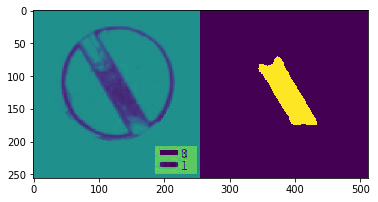

In [26]:
img_path = 'data/5.png'
model_path = 'models/Ranger_Dice_Beta_1_best_loss.pth'
predict(model_path, img_path = img_path)

Folder

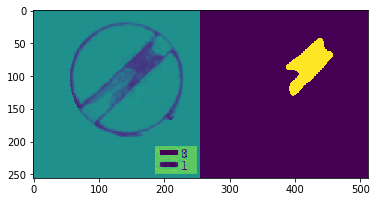

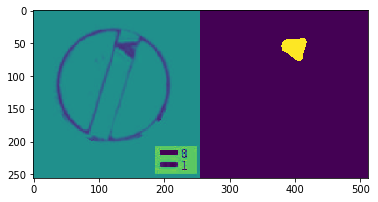

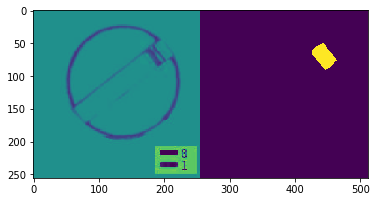

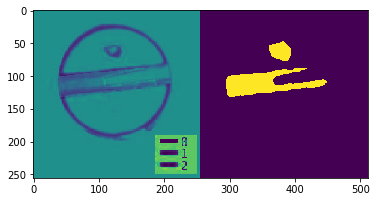

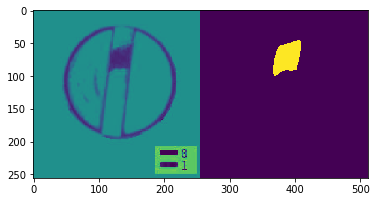

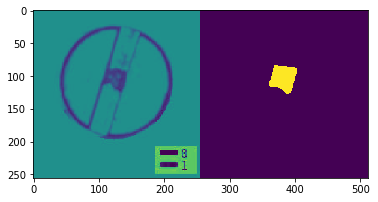

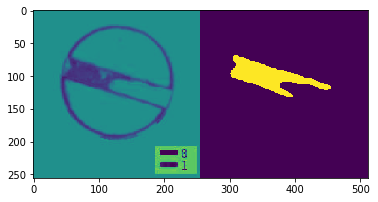

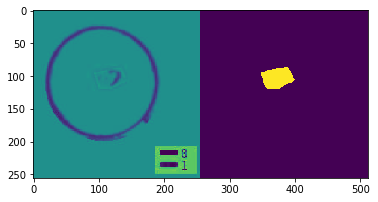

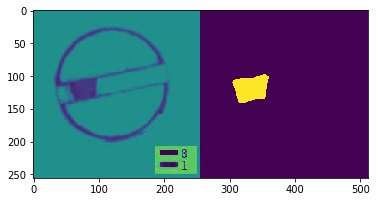

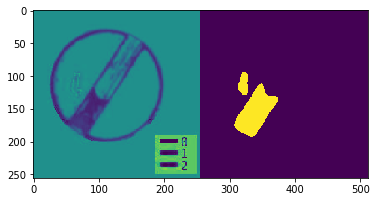

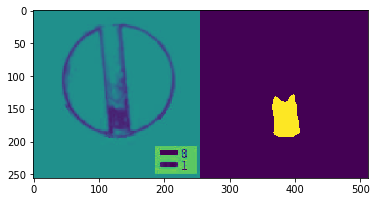

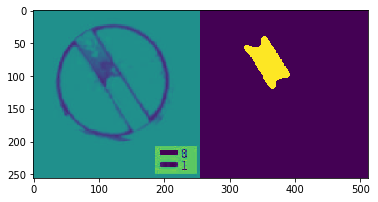

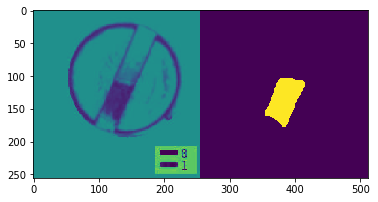

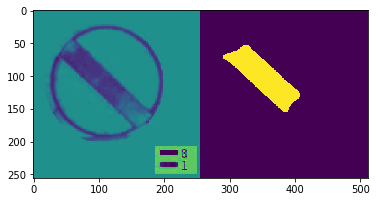

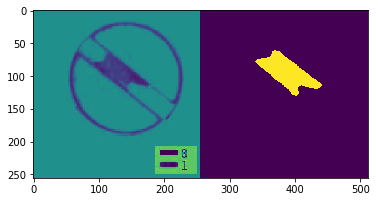

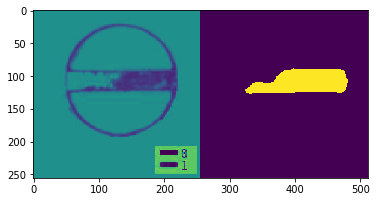

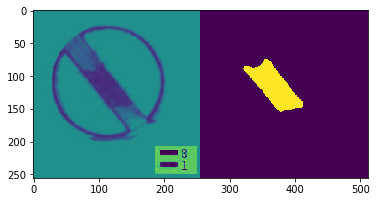

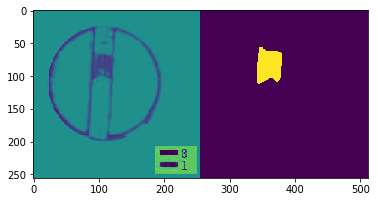

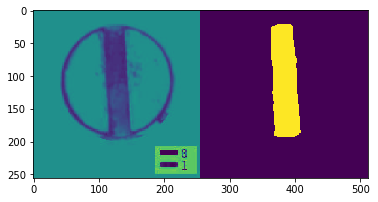

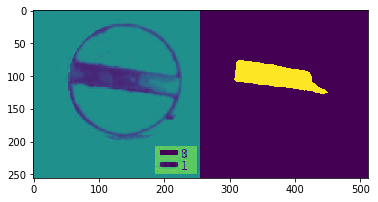

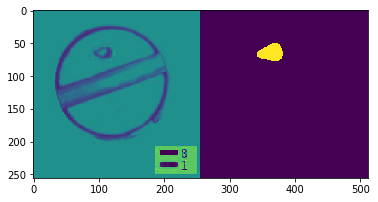

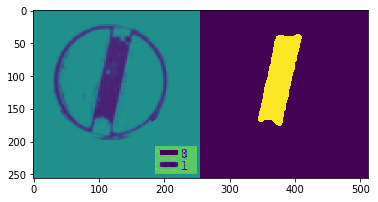

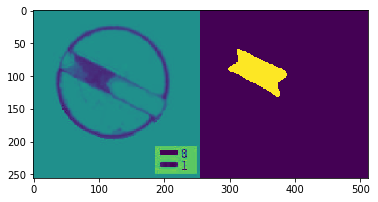

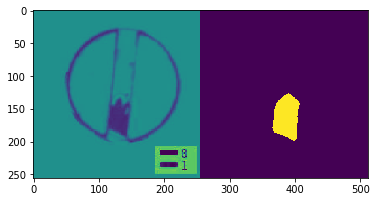

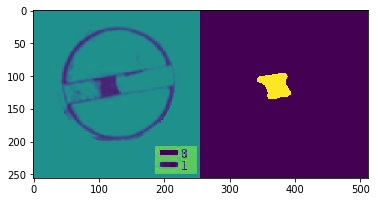

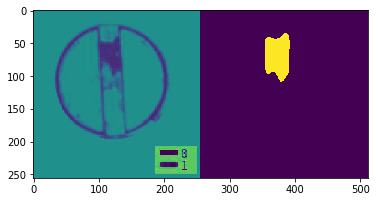

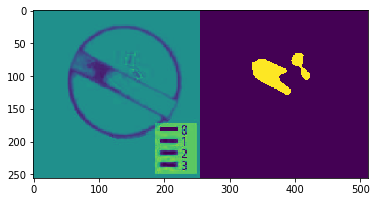

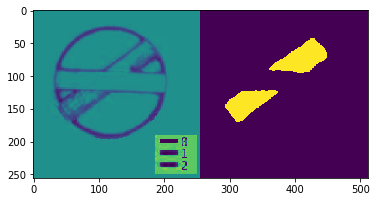

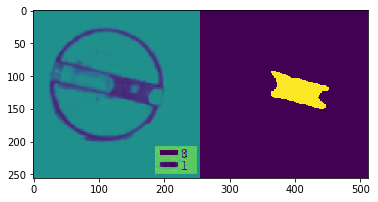

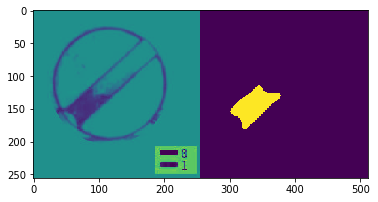

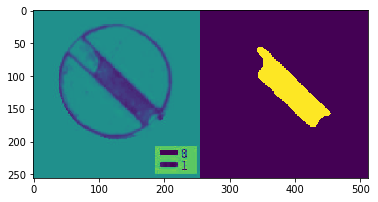

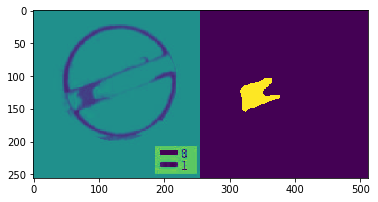

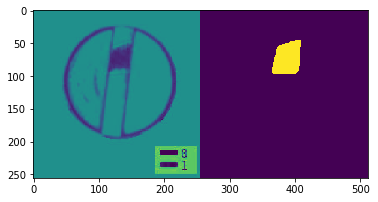

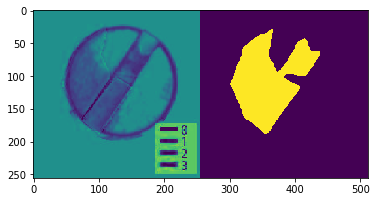

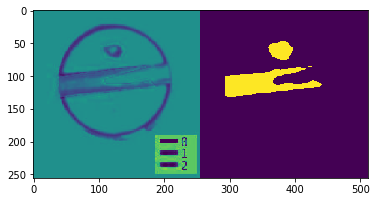

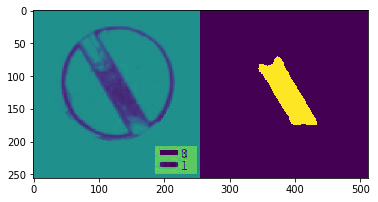

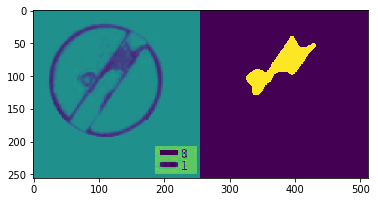

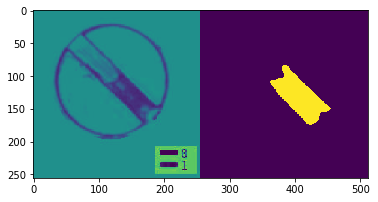

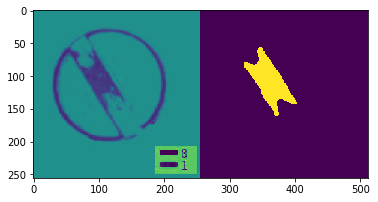

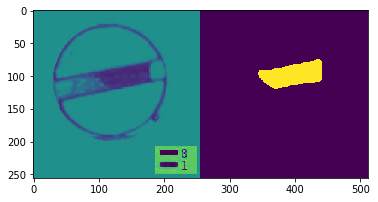

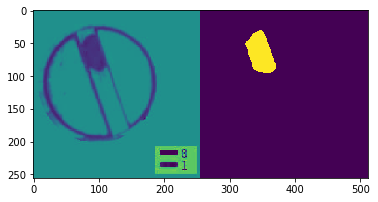

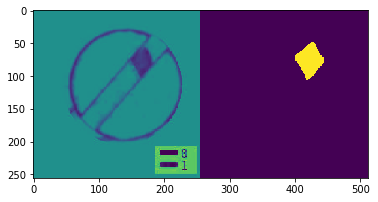

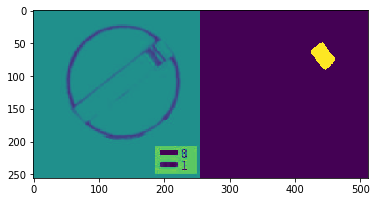

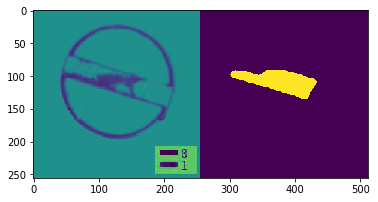

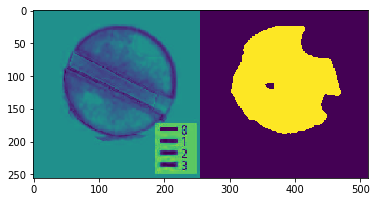

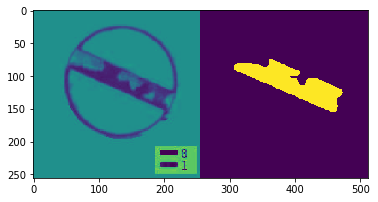

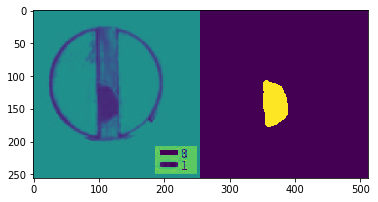

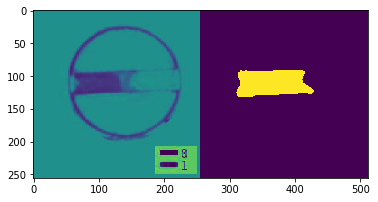

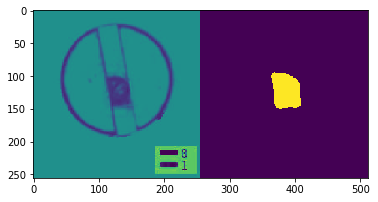

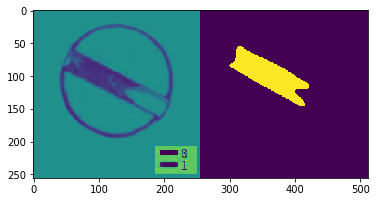

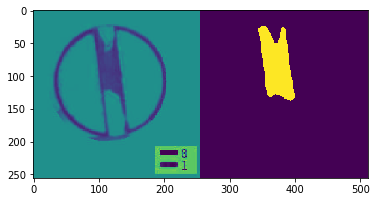

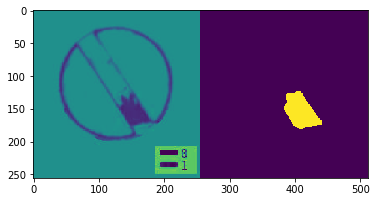

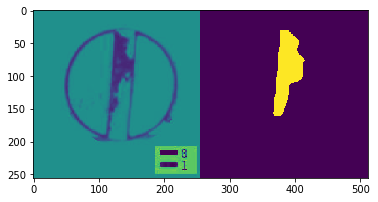

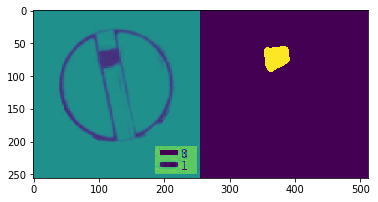

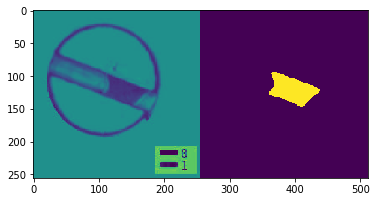

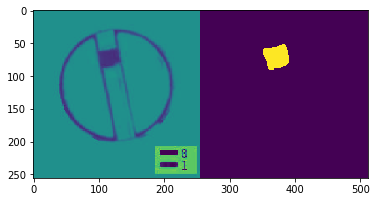

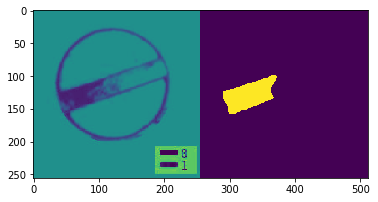

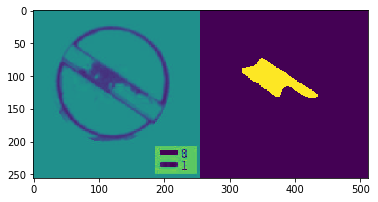

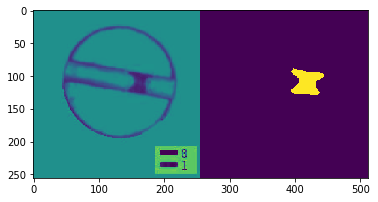

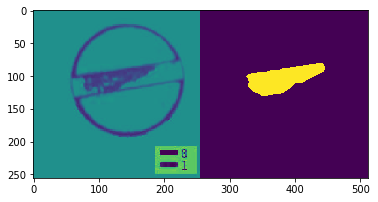

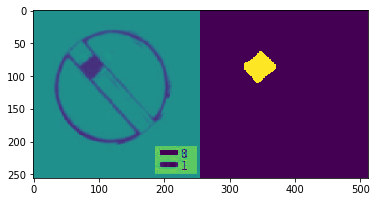

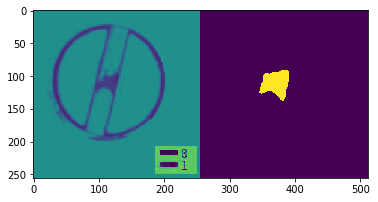

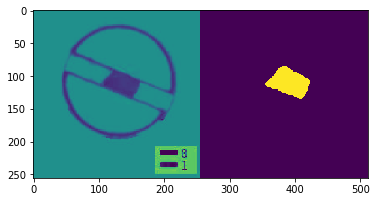

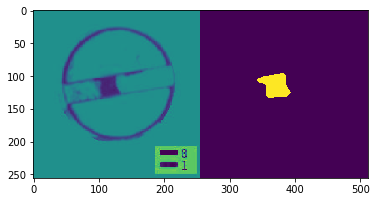

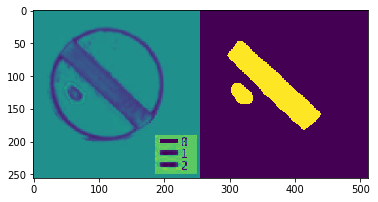

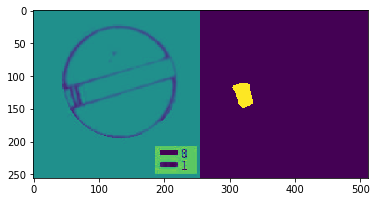

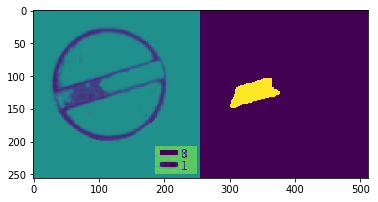

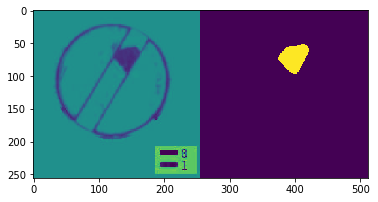

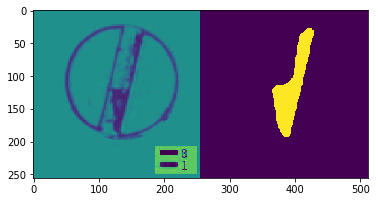

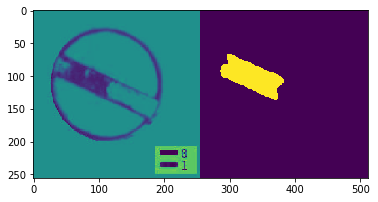

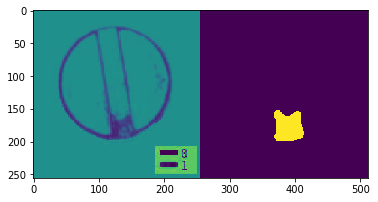

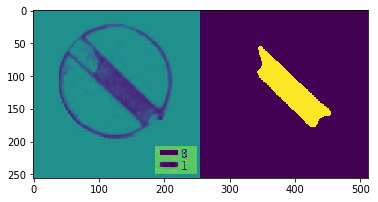

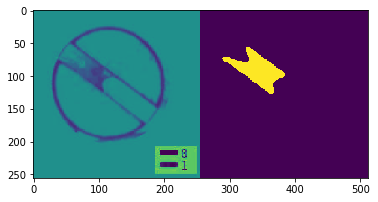

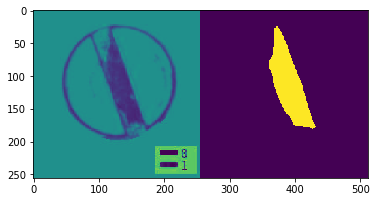

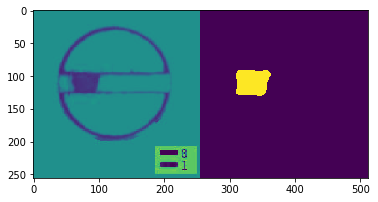

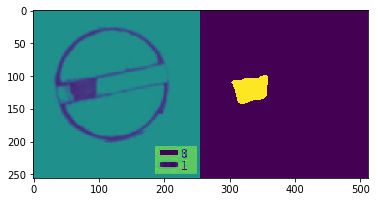

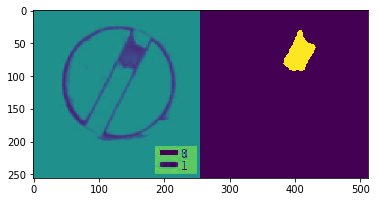

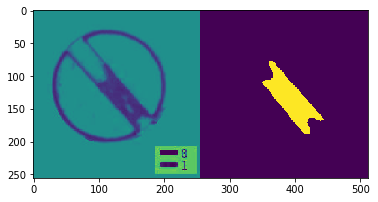

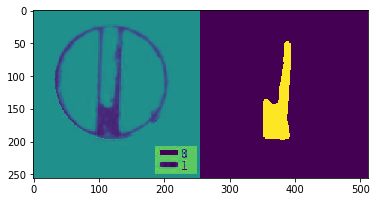

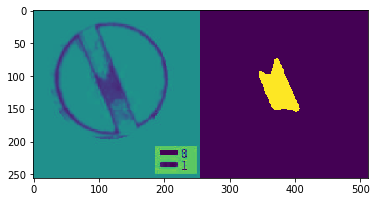

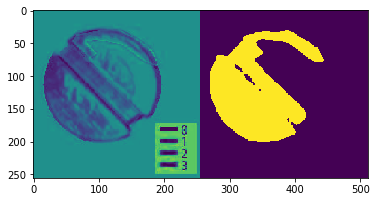

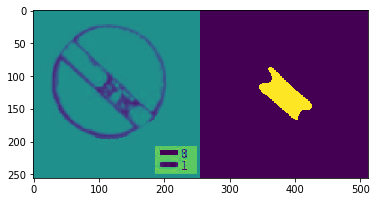

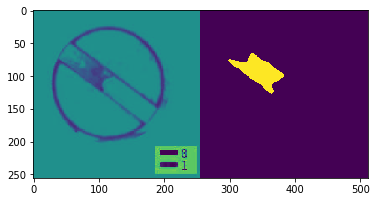

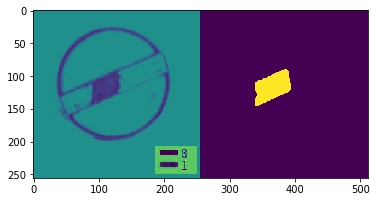

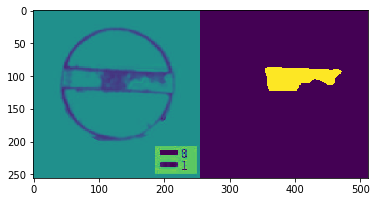

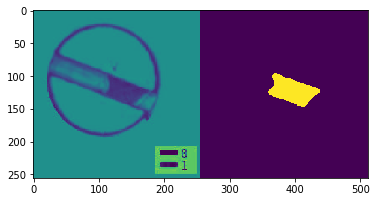

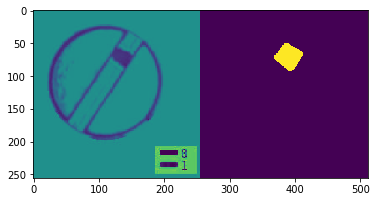

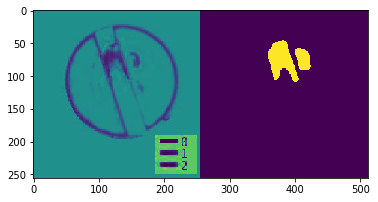

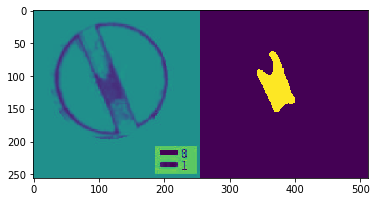

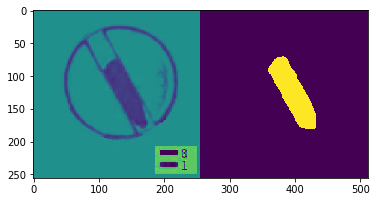

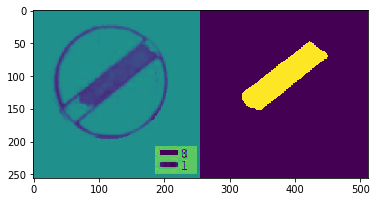

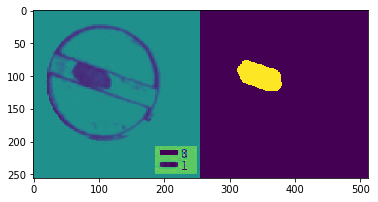

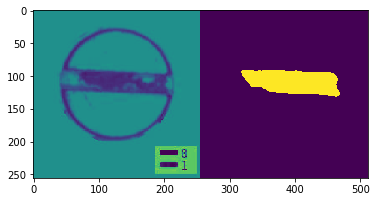

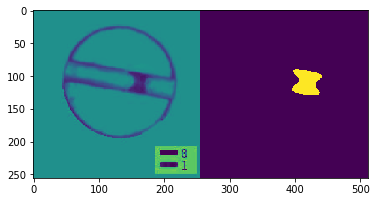

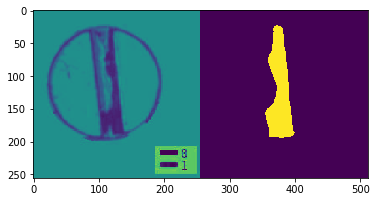

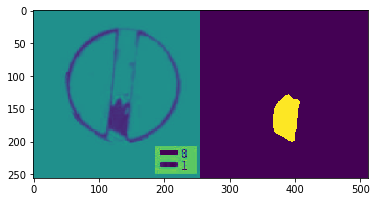

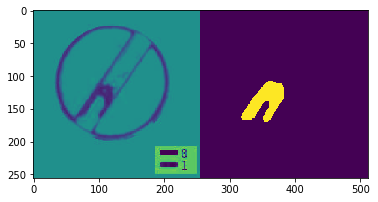

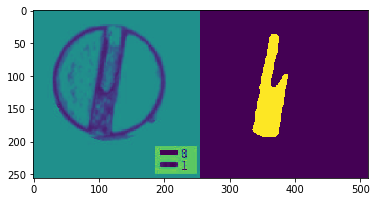

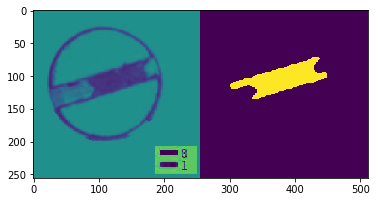

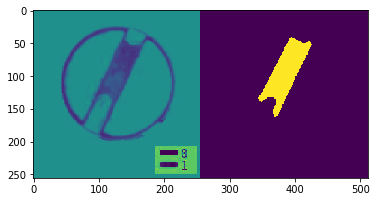

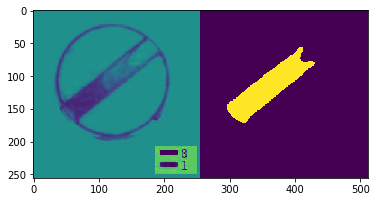

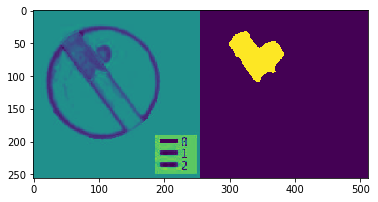

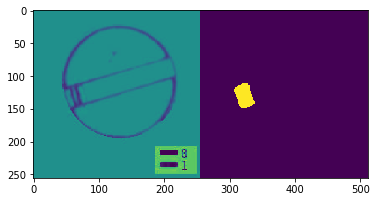

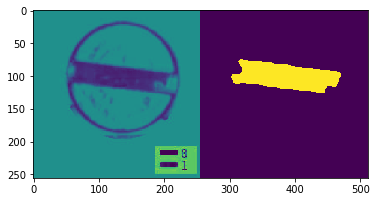

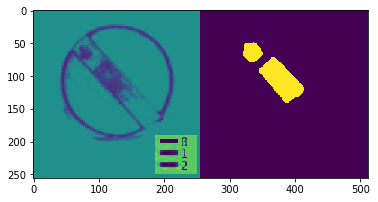

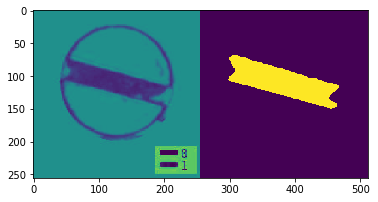

In [27]:
folder_path = 'data'
model_path = 'models/Ranger_Dice_Beta_1_best_loss.pth'
predict(model_path, folder_path = folder_path)